In [5]:
import tensorflow as tf
from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import resource_variable_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import optimizer

class RAdamOptimizer(optimizer.Optimizer):

    """
    RAdam optimizer : On The Variance Of The Adaptive Learning Rate And Beyond
    https://arxiv.org/abs/1908.03265
    """

    def __init__(self,
                 learning_rate=0.001,
                 beta1=0.9,
                 beta2=0.999,
                 epsilon=1e-8,
                 weight_decay=0.,
                 use_locking=False,
                 name="RAdam"):

        super(RAdamOptimizer, self).__init__(use_locking, name)
        self._lr = learning_rate
        self._beta1 = beta1
        self._beta2 = beta2
        self._epsilon = epsilon
        self._weight_decay = weight_decay

        self._lr_t = None
        self._step_t = None
        self._beta1_t = None
        self._beta2_t = None
        self._epsilon_t = None
        self._weight_decay_t = None

    def _get_beta_accumulators(self):
        with ops.init_scope():
            if context.executing_eagerly():
                graph = None
            else:
                graph = ops.get_default_graph()
            return (self._get_non_slot_variable("step", graph=graph),
                    self._get_non_slot_variable("beta1_power", graph=graph),
                    self._get_non_slot_variable("beta2_power", graph=graph))

    def _create_slots(self, var_list):
        first_var = min(var_list, key=lambda x: x.name)
        self._create_non_slot_variable(initial_value=1.0, name="step", colocate_with=first_var)
        self._create_non_slot_variable(initial_value=self._beta1, name="beta1_power", colocate_with=first_var)
        self._create_non_slot_variable(initial_value=self._beta2, name="beta2_power", colocate_with=first_var)

        for v in var_list:
            self._zeros_slot(v, "m", self._name)
            self._zeros_slot(v, "v", self._name)

    def _prepare(self):
        lr = self._call_if_callable(self._lr)
        beta1 = self._call_if_callable(self._beta1)
        beta2 = self._call_if_callable(self._beta2)
        epsilon = self._call_if_callable(self._epsilon)
        weight_decay = self._call_if_callable(self._weight_decay)

        self._lr_t = ops.convert_to_tensor(lr, name="learning_rate")
        self._beta1_t = ops.convert_to_tensor(beta1, name="beta1")
        self._beta2_t = ops.convert_to_tensor(beta2, name="beta2")
        self._epsilon_t = ops.convert_to_tensor(epsilon, name="epsilon")
        self._weight_decay_t = ops.convert_to_tensor(weight_decay, name="weight_decay")

    def _apply_dense(self, grad, var):
        return self._resource_apply_dense(grad, var)

    def _resource_apply_dense(self, grad, var):
        step, beta1_power, beta2_power = self._get_beta_accumulators()
        step = math_ops.cast(step, var.dtype.base_dtype)
        beta1_power = math_ops.cast(beta1_power, var.dtype.base_dtype)
        beta2_power = math_ops.cast(beta2_power, var.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)

        beta1_t = math_ops.cast(self._beta1_t, var.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, var.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

        sma_inf = 2.0 / (1.0 - beta2_t) - 1.0
        sma_t = sma_inf - 2.0 * step * beta2_power / (1.0 - beta2_power)

        m = self.get_slot(var, "m")
        m_t = state_ops.assign(m, beta1_t * m + (1.0 - beta1_t) * grad, use_locking=self._use_locking)
        mhat_t = m_t / (1.0 - beta1_power)

        v = self.get_slot(var, "v")
        v_t = state_ops.assign(v, beta2_t * v + (1.0 - beta2_t) * math_ops.square(grad), use_locking=self._use_locking)
        vhat_t = math_ops.sqrt(v_t / ((1.0 - beta2_power) + epsilon_t))

        r_t = math_ops.sqrt( ((sma_t - 4.0) * (sma_t - 2.0) * sma_inf) / ((sma_inf - 4.0) * (sma_inf - 2.0) * sma_t) )

        var_t = tf.cond(sma_t >= 5.0, lambda : r_t * mhat_t / (vhat_t + epsilon_t), lambda : mhat_t)

        if self._weight_decay > 0.0:
            var_t += math_ops.cast(self._weight_decay_t, var.dtype.base_dtype) * var

        var_update = state_ops.assign_sub(var, lr_t * var_t, use_locking=self._use_locking)

        updates = [var_update, m_t, v_t]

        return control_flow_ops.group(*updates)

    def _apply_sparse_shared(self, grad, var, indices, scatter_add):
        step, beta1_power, beta2_power = self._get_beta_accumulators()
        step = math_ops.cast(step, var.dtype.base_dtype)
        beta1_power = math_ops.cast(beta1_power, var.dtype.base_dtype)
        beta2_power = math_ops.cast(beta2_power, var.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)

        beta1_t = math_ops.cast(self._beta1_t, var.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, var.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

        sma_inf = 2.0 / (1.0 - beta2_t) - 1.0
        sma_t = sma_inf - 2.0 * step * beta2_power / (1.0 - beta2_power)

        m = self.get_slot(var, "m")
        m_scaled_g_values = grad * (1 - beta1_t)
        m_t = state_ops.assign(m, m * beta1_t, use_locking=self._use_locking)

        with ops.control_dependencies([m_t]):
            m_t = scatter_add(m, indices, m_scaled_g_values)

        mhat_t = m_t / (1.0 - beta1_power)

        v = self.get_slot(var, "v")
        v_scaled_g_values = (grad * grad) * (1 - beta2_t)
        v_t = state_ops.assign(v, v * beta2_t, use_locking=self._use_locking)

        with ops.control_dependencies([v_t]):
            v_t = scatter_add(v, indices, v_scaled_g_values)

        vhat_t = math_ops.sqrt(v_t / (1.0 - beta2_power) + epsilon_t)

        r_t = math_ops.sqrt( ((sma_t - 4.0) * (sma_t - 2.0) * sma_inf) / ((sma_inf - 4.0) * (sma_inf - 2.0) * sma_t) )

        var_t = tf.cond(sma_t >= 5.0, lambda : r_t * mhat_t / (vhat_t + epsilon_t), lambda : mhat_t)

        if self._weight_decay > 0.0:
            var_t += math_ops.cast(self._weight_decay_t, var.dtype.base_dtype) * var

        var_update = state_ops.assign_sub(var, lr_t * var_t, use_locking=self._use_locking)

        updates = [var_update, m_t, v_t]

        return control_flow_ops.group(*updates)

    def _apply_sparse(self, grad, var):
        return self._apply_sparse_shared(
            grad.values,
            var,
            grad.indices,
            lambda x, i, v: state_ops.scatter_add(x, i, v, use_locking=self._use_locking))

    def _resource_scatter_add(self, x, i, v):
        with ops.control_dependencies([resource_variable_ops.resource_scatter_add(x.handle, i, v)]):
            return x.value()

    def _resource_apply_sparse(self, grad, var, indices):
        return self._apply_sparse_shared(grad, var, indices, self._resource_scatter_add)

    def _finish(self, update_ops, name_scope):
        with ops.control_dependencies(update_ops):
            step, beta1_power, beta2_power = self._get_beta_accumulators()
            with ops.colocate_with(beta1_power):
                update_step = step.assign(step + 1.0, use_locking=self._use_locking)
                update_beta1 = beta1_power.assign(beta1_power * self._beta1_t, use_locking=self._use_locking)
                update_beta2 = beta2_power.assign(beta2_power * self._beta2_t, use_locking=self._use_locking)
        return control_flow_ops.group(*update_ops + [update_step, update_beta1, update_beta2], name=name_scope)

#### 1. Load bộ dữ liệu (CIFAR10)

In [6]:
from keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()

170508288/170498071 [==============================] - 11s 0us/step


#### 2. Chuẩn bị dữ liệu

In [7]:
from tensorflow.keras.utils import to_categorical

X_train_new = X_train/255.0

X_test_new = X_test/255.0

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

#### 3. Xây dựng mô hình

In [9]:
!pip install keras_radam

  Created wheel for keras-radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14684 sha256=090317602d25f773793a5c70e590bd127324a93c8d0821720dfeacac1d5eb615
  Stored in directory: /root/.cache/pip/wheels/23/6a/5f/d674f3b7b4d504b03148abd675e3703ba00c31763c04a2fc20
Successfully built keras-radam


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
import keras_radam
from tensorflow.keras.losses import CategoricalCrossentropy


EPOCHS = 25
BATCH_SIZE = 128

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [11]:
loss = CategoricalCrossentropy()
optimizer = RAdamOptimizer()

In [12]:
model.compile(optimizer=optimizer, loss=loss, metrics="accuracy")

In [13]:
import time
start = time.time()
history = model.fit(X_train_new, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test_new, y_test))
print('training time = ',time.time()-start)

Epoch 1/25
391/391 [==============================] - 13s 9ms/step - loss: 1.7487 - accuracy: 0.3610 - val_loss: 1.4202 - val_accuracy: 0.4779
Epoch 2/25
391/391 [==============================] - 3s 8ms/step - loss: 1.3434 - accuracy: 0.5195 - val_loss: 1.2672 - val_accuracy: 0.5429
Epoch 3/25
391/391 [==============================] - 3s 8ms/step - loss: 1.1590 - accuracy: 0.5902 - val_loss: 1.1749 - val_accuracy: 0.5794
Epoch 4/25
391/391 [==============================] - 3s 8ms/step - loss: 1.0307 - accuracy: 0.6391 - val_loss: 1.0254 - val_accuracy: 0.6394
Epoch 5/25
391/391 [==============================] - 3s 8ms/step - loss: 0.9376 - accuracy: 0.6707 - val_loss: 0.9446 - val_accuracy: 0.6698
Epoch 6/25
391/391 [==============================] - 3s 8ms/step - loss: 0.8447 - accuracy: 0.7063 - val_loss: 0.8746 - val_accuracy: 0.6951
Epoch 7/25
391/391 [==============================] - 3s 8ms/step - loss: 0.7679 - accuracy: 0.7322 - val_loss: 0.8479 - val_accuracy: 0.7022
Epoch

acc

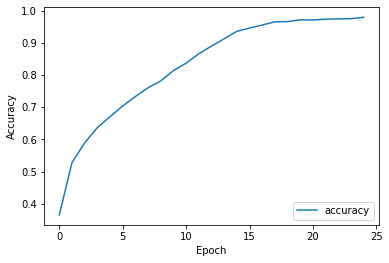

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

val_acc

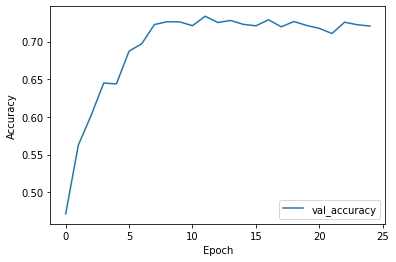

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

loss

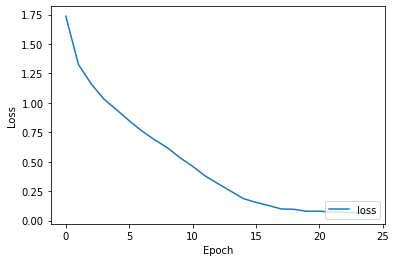

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

val_loss

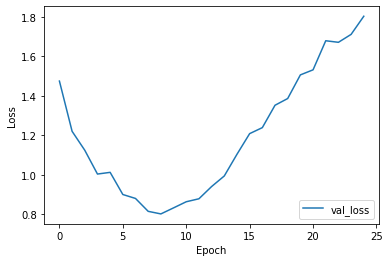

In [ ]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#### ResNet50

In [4]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [5]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [6]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [7]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [8]:
base_model = ResNet50(input_shape=(32, 32, 3))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(10,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [9]:
model_resnet = Model(inputs=base_model.input, outputs=headModel)


In [13]:
from tensorflow.keras.losses import CategoricalCrossentropy

loss = CategoricalCrossentropy()
optimizer = RAdamOptimizer(learning_rate = 1e-3)

In [14]:
model_resnet.compile(optimizer=optimizer, loss=loss, metrics="accuracy")

In [17]:
history_resnet50 = model_resnet.fit(X_train_new, y_train, batch_size=128, epochs=10, validation_data=(X_test_new, y_test))

Epoch 1/10
391/391 [==============================] - 70s 96ms/step - loss: 2.0579 - accuracy: 0.2509 - val_loss: 2.1625 - val_accuracy: 0.2378
Epoch 2/10
391/391 [==============================] - 37s 95ms/step - loss: 1.6462 - accuracy: 0.4005 - val_loss: 1.6193 - val_accuracy: 0.4198
Epoch 3/10
391/391 [==============================] - 36s 92ms/step - loss: 1.4361 - accuracy: 0.4834 - val_loss: 1.4921 - val_accuracy: 0.4674
Epoch 4/10
391/391 [==============================] - 37s 95ms/step - loss: 1.2955 - accuracy: 0.5358 - val_loss: 1.4039 - val_accuracy: 0.5103
Epoch 5/10
391/391 [==============================] - 36s 92ms/step - loss: 1.1809 - accuracy: 0.5805 - val_loss: 1.3643 - val_accuracy: 0.5324
Epoch 6/10
391/391 [==============================] - 36s 92ms/step - loss: 1.0850 - accuracy: 0.6143 - val_loss: 1.4504 - val_accuracy: 0.5114
Epoch 7/10
391/391 [==============================] - 36s 92ms/step - loss: 0.9986 - accuracy: 0.6515 - val_loss: 1.2816 - val_accuracy:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import pandas as pd


history_resnet50_df = pd.DataFrame(history_resnet50.history) 
history_resnet50_df.to_csv('history_resnet50.csv', index=False)